 # 🏦 Dashen Bank Customer Churn Analysis & Prediction
 
 
**📌 Project Title:**
**Customer Churn Analysis and Predictive Modeling for Dashen Bank**

**📌 Domain:**
Banking & Financial Services

**📌 Objective:**
To analyze customer behavior at Dashen Bank and build a machine learning model that predicts customer churn, enabling proactive retention strategies.

**📌 Problem Type:**
Binary Classification (Churn / No Churn)

 
**Platform:** Kaggle Notebook  
**Tools:** Python, Pandas, Scikit-Learn, Matplotlib, Seaborn  


## Business Understanding & Success Metrics

Customer churn has a direct financial impact on banks due to lost revenue and increased acquisition costs.
Predicting churn allows the bank to intervene early and retain valuable customers.

### Why Accuracy Alone Is Not Enough
The dataset is imbalanced, with fewer churned customers than retained ones.
A model predicting "No Churn" for everyone could achieve high accuracy but fail in practice.

### Chosen Evaluation Metrics
- **Recall:** Measures how many actual churners are correctly identified
- **Precision:** Measures how reliable churn predictions are
- **F1-score:** Balances precision and recall
- **ROC-AUC:** Measures overall model discrimination ability

Business decisions prioritize **recall**, as missing a churner is more costly than a false alert.

In [1]:
# Kaggle Environment Setup
import warnings, os, sys, platform, json, hashlib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
warnings.filterwarnings('ignore', message='.*use_label_encoder.*')
warnings.filterwarnings('ignore', category=FutureWarning)

import sklearn, xgboost
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("sklearn:", sklearn.__version__, "| xgboost:", xgboost.__version__)
np.random.seed(42)
RANDOM_STATE = 42

Python: 3.12.12 | Platform: Linux-6.6.105+-x86_64-with-glibc2.35
sklearn: 1.6.1 | xgboost: 3.1.0


## Data Loading & Initial Inspection

The dataset contains customer demographic, account, and behavioral features.
Initial inspection helps identify data types, missing values, and the distribution of the target variable.

In [2]:
# Data Loading — auto-discover CSV under /kaggle/input
def find_csv(folder_hint=None):
    base = "/kaggle/input"
    search_root = os.path.join(base, folder_hint) if folder_hint else base
    for root, _, files in os.walk(search_root):
        for f in files:
            if f.lower().endswith('.csv'):
                return os.path.join(root, f)
    return None

CSV_PATH = find_csv()
if not CSV_PATH:
    raise FileNotFoundError("CSV not found under /kaggle/input. Please attach your dataset.")

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "shape:", df.shape)
display(df.head())
display(df.dtypes)

with open(CSV_PATH, 'rb') as f:
    dataset_sha256 = hashlib.sha256(f.read()).hexdigest()
print("Dataset SHA256:", dataset_sha256)

Loaded: /kaggle/input/db-datasets/dashen_bank.csv shape: (10000, 16)


,CustomerID,Gender,Age,Region,City,Branch,HasPartner,TenureYears,AccountType,HasMobileBanking,HasCreditCard,IsActiveMember,Balance_ETB,MonthlyServiceFee_ETB,NumberOfTransactions,Exited
0,5808053162473,Male,87,Addis Ababa (Chartered City),Addis Ababa,Kotebe Zero Hulet Branch,Yes,NaN,Savings,No,Yes,Yes,4223.41,129.23,270.0,No
1,5306404042870,Male,61,Amhara Region,Bahir Dar,Bahir Dar Stadium Branch,Yes,22.5,Current,Yes,Yes,Yes,1526.37,175.43,87.0,No
2,5847087372942,Female,47,Sidama Region,Hawassa,Tabor Branch,Yes,5.7,Current,Yes,No,Yes,1387.46,169.23,130.0,No
3,5704054194082,Male,25,Oromia Region,Nekemte,Nekemte Main Branch,Yes,12.3,Current,Yes,Yes,Yes,1823.50,132.05,21.0,No
4,5617380026649,Female,72,SNNPR (Southern Nations),Wolkite,Wolkite Branch,No,5.4,Savings,No,Yes,Yes,209.99,35.98,58.0,No


CustomerID                 int64
Gender                    object
Age                        int64
Region                    object
City                      object
Branch                    object
HasPartner                object
TenureYears              float64
AccountType               object
HasMobileBanking          object
HasCreditCard             object
IsActiveMember            object
Balance_ETB              float64
MonthlyServiceFee_ETB    float64
NumberOfTransactions     float64
Exited                    object
dtype: object

Dataset SHA256: fe2ff81638cd2f0a05a6237d3c1ab2ec70bc6b34b407637cd6d5e1826e2683e3


## Data Dictionary

A concise data dictionary to document features for reviewers and stakeholders. Expand with full descriptions when preparing reports.

| Feature Name | Type | Description |
|---|---|---|
| CustomerID | Categorical | Unique customer identifier |
| TenureYears | Numeric | Years since account opening |
| Branch | Categorical | Bank branch name |
| City | Categorical | City of residence |
| Balance | Numeric | Account balance |
| Balance_ETB | Numeric | Account balance in ETB (if applicable) |
| CityType_Formal | Categorical | City classification (Chartered/Regional/Rural) |
| BranchType_Formal | Categorical | Branch category (Main/Sub) |
| Exited | Binary | Churn indicator (1 = churned) |

Place this immediately after data loading to ensure reviewers see feature meanings and units.

In [3]:
# Target Normalization — ensure binary 0/1 in TARGET_COL
from pandas.api import types as pdtypes

TARGET_COL = 'Exited'
if TARGET_COL not in df.columns:
    raise KeyError(f"{TARGET_COL} not found in dataset.")

def ensure_target_binary(df_in, col):
    s = df_in[col]
    if pdtypes.is_numeric_dtype(s) and set(s.dropna().unique()).issubset({0,1}):
        return df_in
    s_str = s.astype(str).str.strip().str.lower()
    pos = {'yes','y','true','t','1','exited','churn','churned'}
    neg = {'no','n','false','f','0','retained','stay','stayed'}
    if s_str.isin(pos.union(neg)).all():
        df_in[col] = s_str.map(lambda x: 1 if x in pos else 0).astype(int)
        return df_in
    coerced = pd.to_numeric(s_str.str.replace(r'[^0-9\.-]','', regex=True), errors='coerce')
    if coerced.dropna().isin([0,1]).all():
        df_in[col] = coerced.fillna(0).astype(int)
        return df_in
    uniq = list(pd.unique(s_str.dropna()))
    if len(uniq) == 2:
        counts = s_str.value_counts()
        major = counts.idxmax(); minor = [v for v in uniq if v != major][0]
        df_in[col] = s_str.map(lambda x: 0 if x == major else 1).astype(int)
        return df_in
    raise ValueError("Cannot infer binary target mapping; please clean the label column.")

df = ensure_target_binary(df, TARGET_COL)
print('Target distribution:')
display(df[TARGET_COL].value_counts(dropna=False))
print('Churn rate:', df[TARGET_COL].mean())

Target distribution:


Exited
0    7063
1    2937
Name: count, dtype: int64

Churn rate: 0.2937


## Missing-Value Analysis (explicit table)
We produce a table with percent missing and the strategy used for each column (imputation or other). This makes the handling transparent for reviewers.

In [4]:
# Missing-value summary table
missing_df = pd.DataFrame({
    'missing_pct': df.isna().mean() * 100,
    'missing_count': df.isna().sum()
}).sort_values('missing_pct', ascending=False)
display(missing_df)

# Example strategy column (manual; expand per-dataset)
def default_strategy(col):
    if col == TARGET_COL:
        return 'N/A (target)'
    if df[col].dtype.kind in 'biufc':
        return 'median imputation or indicator for fully-missing'
    return 'constant imputation (Unknown) or mode'

missing_df['strategy'] = missing_df.index.map(default_strategy)
display(missing_df)

,missing_pct,missing_count
NumberOfTransactions,7.42,742
HasPartner,7.36,736
AccountType,7.19,719
HasCreditCard,7.05,705
Balance_ETB,7.00,700
MonthlyServiceFee_ETB,6.83,683
Gender,6.76,676
TenureYears,6.61,661
City,0.00,0
Branch,0.00,0


,missing_pct,missing_count,strategy
NumberOfTransactions,7.42,742,median imputation or indicator for fully-missing
HasPartner,7.36,736,constant imputation (Unknown) or mode
AccountType,7.19,719,constant imputation (Unknown) or mode
HasCreditCard,7.05,705,constant imputation (Unknown) or mode
Balance_ETB,7.00,700,median imputation or indicator for fully-missing
MonthlyServiceFee_ETB,6.83,683,median imputation or indicator for fully-missing
Gender,6.76,676,constant imputation (Unknown) or mode
TenureYears,6.61,661,median imputation or indicator for fully-missing
City,0.00,0,constant imputation (Unknown) or mode
Branch,0.00,0,constant imputation (Unknown) or mode


## Exploratory Data Analysis (EDA)

EDA is performed to understand customer behavior patterns and their relationship with churn.
This includes analyzing age, balance, tenure, and activity status against the churn variable.

EDA also helps detect class imbalance and potential bias in the data.

## Target EDA

Visualize the churn label distribution.

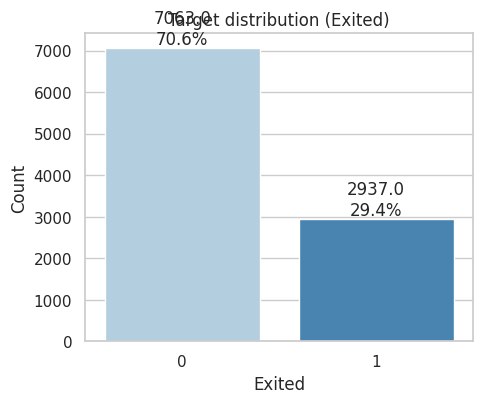

Note: If churn is rare, accuracy is misleading. Prefer ROC-AUC and PR analysis.


In [5]:
# Target EDA
plt.figure(figsize=(5,4))
ax = sns.countplot(x=TARGET_COL, data=df, palette='Blues')
total = len(df)
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f"{h}\n{h/total:.1%}", (p.get_x()+p.get_width()/2., h), ha='center', va='bottom')
plt.title('Target distribution (Exited)')
plt.xlabel('Exited'); plt.ylabel('Count')
plt.show()
print('Note: If churn is rare, accuracy is misleading. Prefer ROC-AUC and PR analysis.')

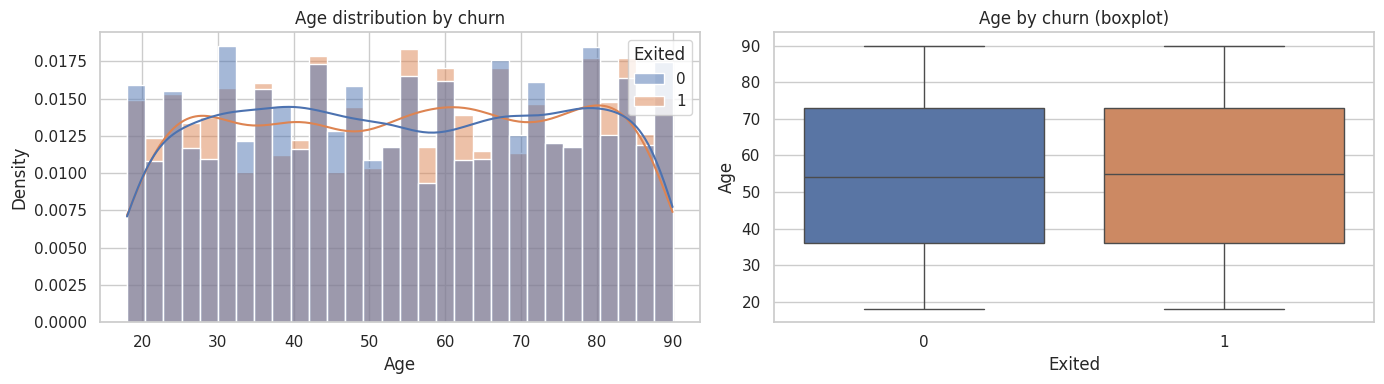

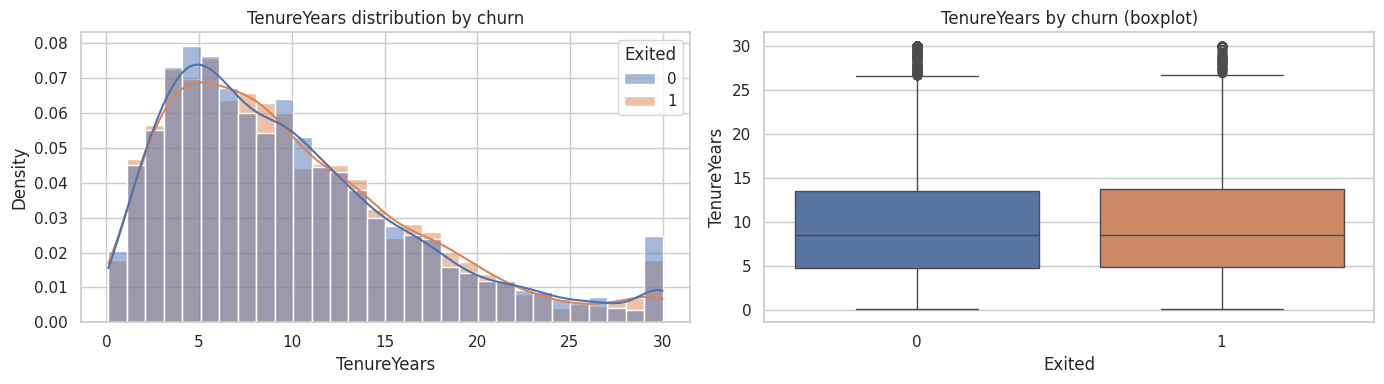

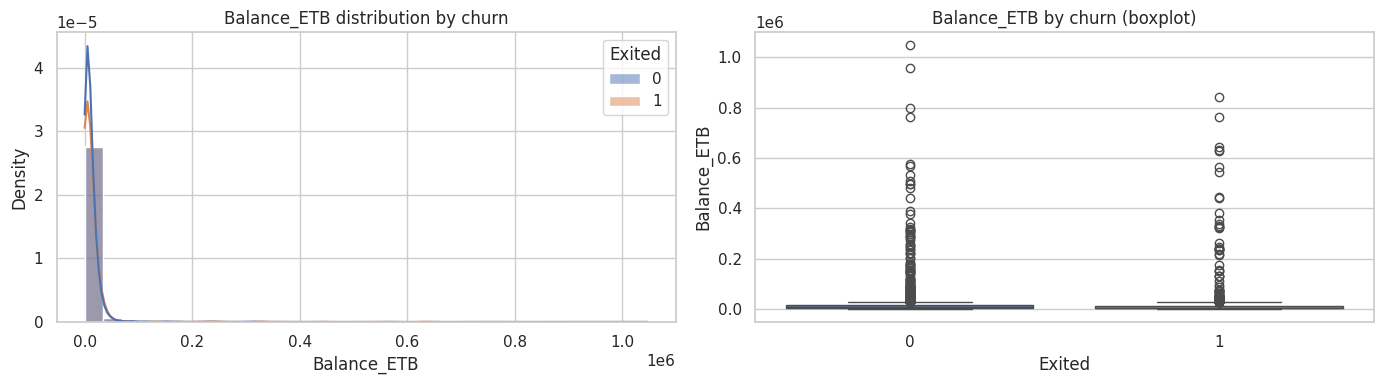

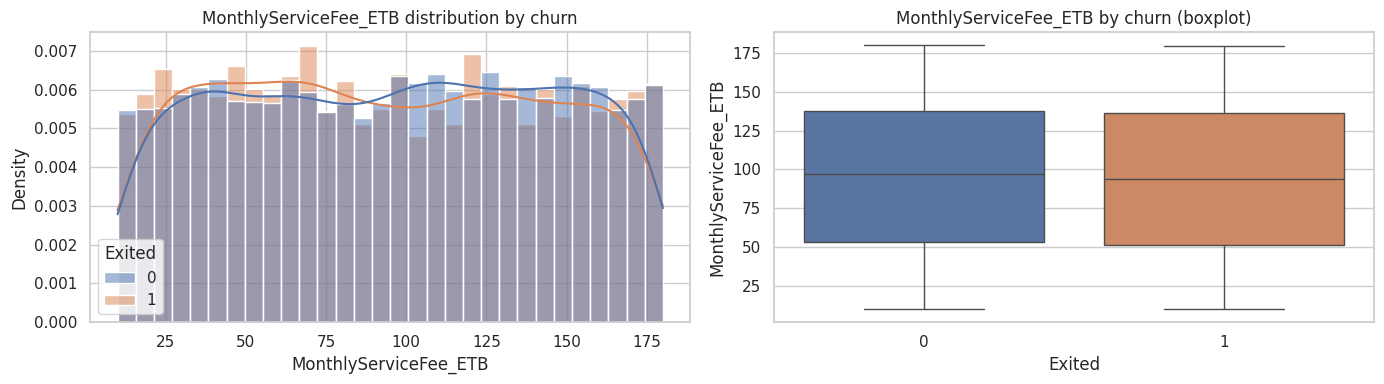

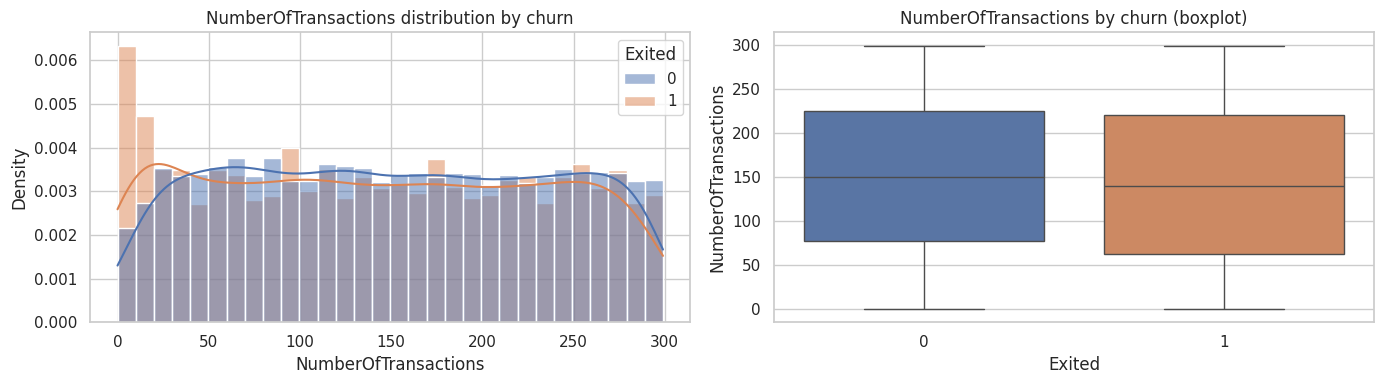

In [6]:
# EDA Cell — Numeric distributions and churn comparison
# Paste this cell in place of your previous numeric-EDA cell.

# Ensure numeric column list exists
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET_COL]

# Preferred key numeric features to highlight (fall back to first numeric cols)
key_numeric = [c for c in ['Age','TenureYears','Balance_ETB','MonthlyServiceFee_ETB','NumberOfTransactions'] if c in df.columns]
if not key_numeric:
    key_numeric = num_cols[:5]

# Plot paired histogram (by churn) + boxplot for each selected numeric feature
for col in key_numeric:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(data=df, x=col, hue=TARGET_COL, bins=30, kde=True,
                 stat='density', common_norm=False, ax=axes[0],
                 palette=['#4c72b0','#dd8452'])
    axes[0].set_title(f'{col} distribution by churn')
    sns.boxplot(x=TARGET_COL, y=col, data=df, ax=axes[1], palette=['#4c72b0','#dd8452'])
    axes[1].set_title(f'{col} by churn (boxplot)')
    plt.tight_layout()
    plt.show()

 

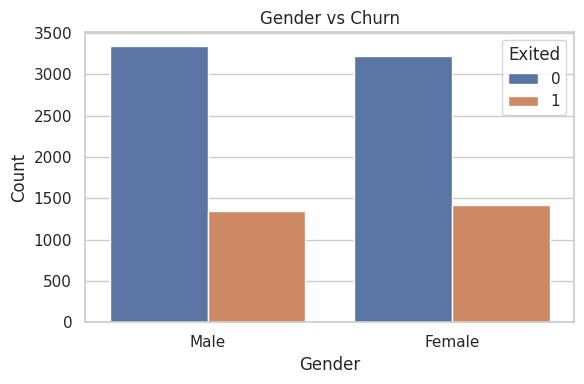

Churn rate by Gender


,Gender,churn_rate
0,Female,0.305651
1,Male,0.286903


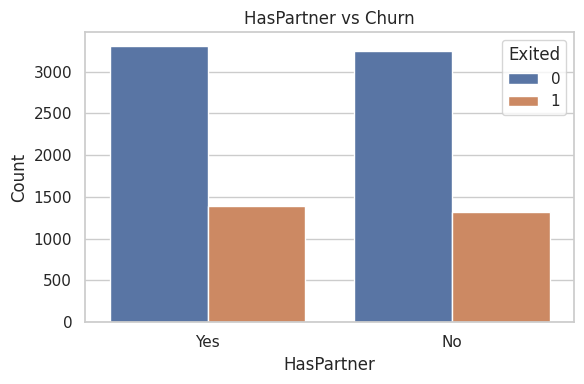

Churn rate by HasPartner


,HasPartner,churn_rate
0,No,0.289347
1,Yes,0.297108


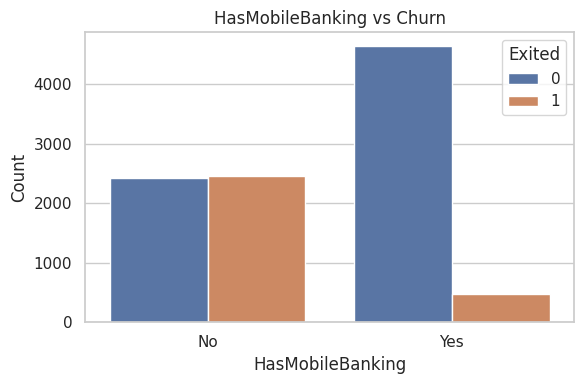

Churn rate by HasMobileBanking


,HasMobileBanking,churn_rate
0,No,0.503486
1,Yes,0.094067


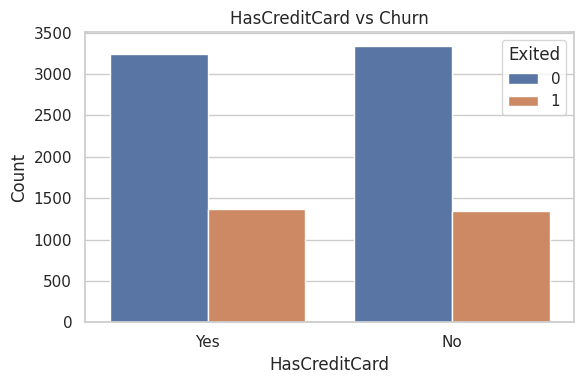

Churn rate by HasCreditCard


,HasCreditCard,churn_rate
0,No,0.287727
1,Yes,0.296963


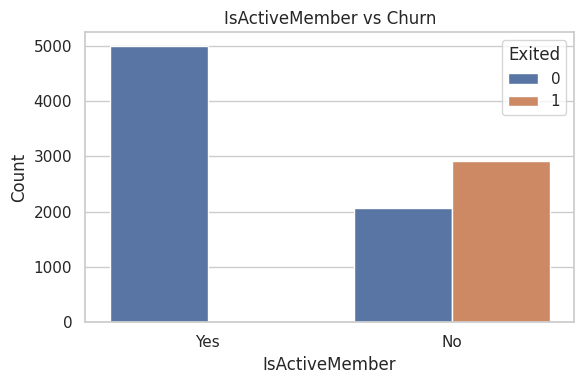

Churn rate by IsActiveMember


,IsActiveMember,churn_rate
0,No,0.585288
1,Yes,0.003393


In [7]:
# EDA Cell — Binary features vs churn
# Adds per-category counts and churn rates for binary features.

# Ensure target variable name compatibility
try:
    TARGET
except NameError:
    TARGET = TARGET_COL

# If binary_cols not defined, infer simple binary columns (excluding target)
try:
    binary_cols
except NameError:
    binary_cols = [c for c in df.columns if c != TARGET and df[c].dropna().nunique() == 2]

# Plot counts and show churn rates
for col in binary_cols:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x=col, hue=TARGET, data=df, palette=['#4c72b0','#dd8452'])
    plt.title(f'{col} vs Churn')
    plt.xlabel(col); plt.ylabel('Count')
    plt.legend(title='Exited')
    plt.tight_layout(); plt.show()

    rates = df.groupby(col)[TARGET].mean().reset_index().rename(columns={TARGET: 'churn_rate'})
    print('Churn rate by', col)
    display(rates)
 

Columns with missingness > 0:


NumberOfTransactions     0.0742
HasPartner               0.0736
AccountType              0.0719
HasCreditCard            0.0705
Balance_ETB              0.0700
MonthlyServiceFee_ETB    0.0683
Gender                   0.0676
TenureYears              0.0661
dtype: float64

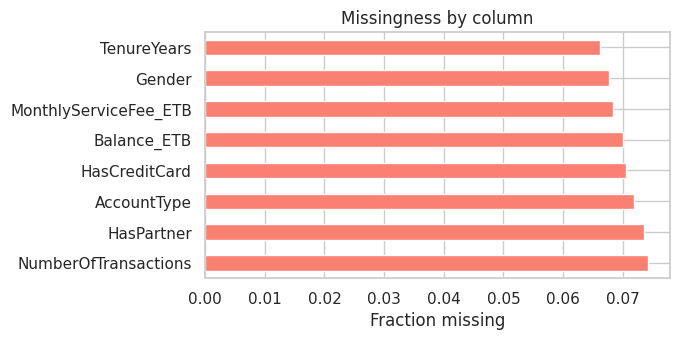


Interpretation hint: High missingness in Balance_ETB may indicate dormant accounts or data collection issues.


In [8]:
# Missingness Pattern Analysis — % missing and heatmap/bar (existing)
missing_pct = df.isna().mean().sort_values(ascending=False)
print('Columns with missingness > 0:')
display(missing_pct[missing_pct > 0])

if missing_pct[missing_pct > 0].any():
    plt.figure(figsize=(6, max(3, 0.2*missing_pct.shape[0])))
    missing_pct[missing_pct > 0].plot(kind='barh', color='salmon')
    plt.xlabel('Fraction missing'); plt.title('Missingness by column')
    plt.show()
 

print('\nInterpretation hint: High missingness in Balance_ETB may indicate dormant accounts or data collection issues.')

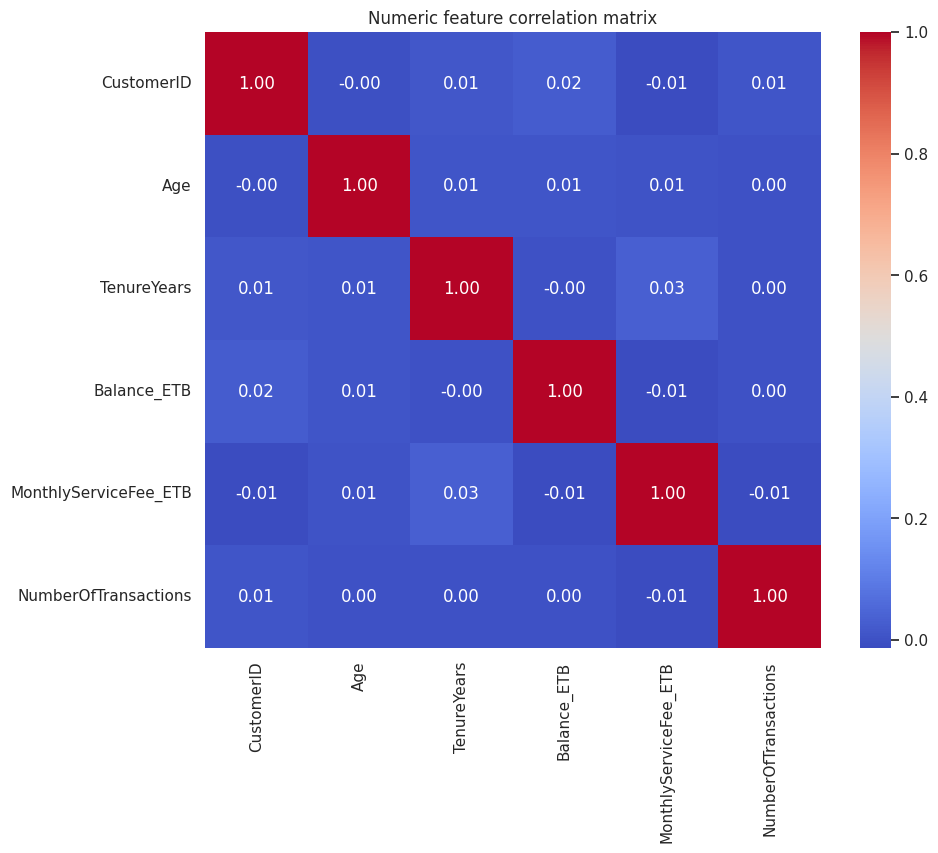

,feature,VIF
4,MonthlyServiceFee_ETB,1.001244
2,TenureYears,1.001002
0,CustomerID,1.000915
3,Balance_ETB,1.000750
1,Age,1.000170
5,NumberOfTransactions,1.000167


In [9]:
# Correlation matrix and optional VIF for multicollinearity (useful for Logistic Regression)
try:
    if len(num_cols) >= 2:
        plt.figure(figsize=(10,8))
        corr = df[num_cols].corr()
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
        plt.title('Numeric feature correlation matrix')
        plt.show()
    else:
        print('Not enough numeric columns for correlation matrix.')
    
    # VIF (variance inflation factor) calculation
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import statsmodels.api as sm
    numeric_for_vif = [c for c in num_cols if df[c].notna().sum() > 0]
    if len(numeric_for_vif) >= 2:
        X_vif = df[numeric_for_vif].fillna(df[numeric_for_vif].median())
        X_vif_const = sm.add_constant(X_vif)
        vif_rows = []
        for i, col in enumerate(X_vif.columns, start=1):
            vif_rows.append({'feature': col, 'VIF': variance_inflation_factor(X_vif_const.values, i)})
        vif_df = pd.DataFrame(vif_rows).sort_values('VIF', ascending=False)
        display(vif_df)
    else:
        print('Not enough numeric features for VIF calculation')
except Exception as e:
    print('Correlation/VIF analysis skipped:', e)

### Methodology & Temporal / Business Realism Disclaimer

If the dataset contains explicit timestamps or an order of events, time-aware splits (train/val/test by time) are preferred to avoid temporal leakage and to reflect production. This project uses random stratified splits because the provided data appears to be a static snapshot with no explicit temporal ordering. A time-aware split utility is included and will be used if timestamp columns are detected.

In [10]:
# Time-aware split utility — run before stratified split and override if timestamps exist
possible_date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
time_split_applied = False
if possible_date_cols:
    print("Possible date columns found:", possible_date_cols)
    date_col = possible_date_cols[0]
    try:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        if df[date_col].notna().sum() > 0.5 * len(df):
            print(f"Using time-aware split on {date_col}")
            df_sorted = df.sort_values(by=date_col)
            n = len(df_sorted)
            test_start = int(n * 0.85)
            val_start = int(n * 0.70)
            train_df = df_sorted.iloc[:val_start]
            val_df = df_sorted.iloc[val_start:test_start]
            test_df = df_sorted.iloc[test_start:]
            X_train, y_train = train_df.drop(columns=[TARGET_COL]), train_df[TARGET_COL]
            X_val, y_val = val_df.drop(columns=[TARGET_COL]), val_df[TARGET_COL]
            X_test, y_test = test_df.drop(columns=[TARGET_COL]), test_df[TARGET_COL]
            time_split_applied = True
        else:
            print("Not enough non-null timestamps — falling back to stratified random split.")
    except Exception as e:
        print("Time-aware splitting skipped:", e)
else:
    print("No obvious timestamp column found — using stratified random split (existing behavior).")

No obvious timestamp column found — using stratified random split (existing behavior).


## 4️⃣ Advanced Business Logic & Domain-Driven Feature Engineering

In this section, we incorporate **Dashen Bank’s operational and geographic realities**
into the dataset. These transformations convert raw data into **business-aware signals**
that improve interpretability and predictive power.

### 🏙️ Detailed City Type Classification

Dashen Bank's geographic footprint is categorized based on administrative hierarchy and economic significance:

- **Federal Capital**: Addis Ababa (Economic and political hub).
- **Regional Capital**: Major cities like Bahir Dar, Hawassa, Mekelle, and Dire Dawa.
- **Zonal Capital**: Key secondary cities and administrative zonal centers (e.g., Adama, Gondar, Jimma).
- **Zonal Town**: Growing urban centers like Shashemene.
- **District Town**: Smaller district-level towns (e.g., Bekoji, Ambo, Lalibela).

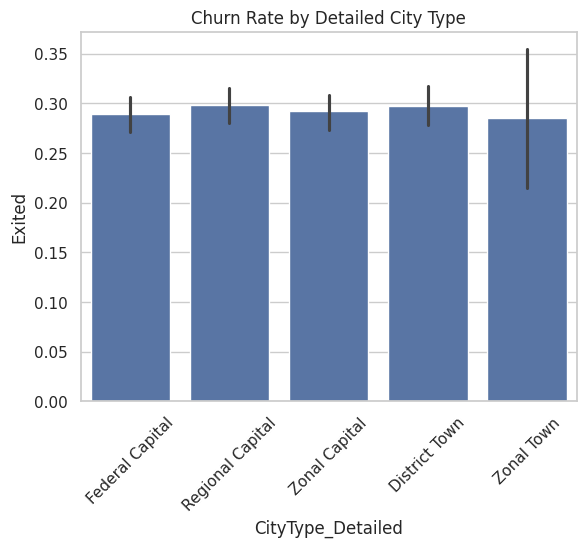

In [11]:
# Define Detailed Mappings based on Dashen Bank Operational structure
city_type_map = {
    'Addis Ababa': 'Federal Capital',
    'Bahir Dar': 'Regional Capital', 'Hawassa': 'Regional Capital', 
    'Dire Dawa': 'Regional Capital', 'Mekelle': 'Regional Capital', 
    'Jijiga': 'Regional Capital', 'Gambella': 'Regional Capital',
    'Nekemte': 'Zonal Capital', 'Wolkite': 'Zonal Capital', 
    'Dilla': 'Zonal Capital', 'Adama': 'Zonal Capital', 
    'Asella': 'Zonal Capital', 'Metu': 'Zonal Capital', 
    'Dessie': 'Zonal Capital', 'Jimma': 'Zonal Capital', 
    'Arba Minch': 'Zonal Capital', 'Wolaita Sodo': 'Zonal Capital', 
    'Gondar': 'Zonal Capital',
    'Shashemene': 'Zonal Town',
    'Bekoji': 'District Town', 'Halaba': 'District Town', 
    'Wondogenet': 'District Town', 'Lalibela': 'District Town', 
    'Ambo': 'District Town'
}

branch_type_map = {
    'Head Office': 'Main', 'Bahir Dar Main Branch': 'Main', 
    'Nekemte Main Branch': 'Main', 'Dire Dawa Main Branch': 'Main', 
    'Dessie Main Branch': 'Main',
    'Bahir Dar Stadium Branch': 'Sub', 'Bilal Branch': 'Sub', 
    'Giorgis Branch': 'Sub', 'Tabor Branch': 'Sub', 
    'Hawassa Tabor Branch': 'Sub', 'Melka Jebdu Branch': 'Sub', 
    'Halaba Kulito Branch': 'Sub', 'Jijiga Taiwan Branch': 'Sub', 
    'Gambella New Land Sub Branch': 'Sub'
}

df['CityType_Detailed'] = df['City'].map(city_type_map).fillna('District Town')
df['BranchType_Detailed'] = df['Branch'].map(branch_type_map).fillna('Standard')

sns.barplot(data=df, x='CityType_Detailed', y='Exited')
plt.title("Churn Rate by Detailed City Type")
plt.xticks(rotation=45)
plt.show()

### 🏛️ Detailed Branch Type Classification

Branches are tiered based on their operational scale and strategic positioning within the bank's network:

- **Main**: Large-scale hub branches and Head Office (Highest transaction intensity).
- **Sub**: Smaller satellite branches providing essential services.
- **Standard**: Regular full-service branches across urban and regional areas.

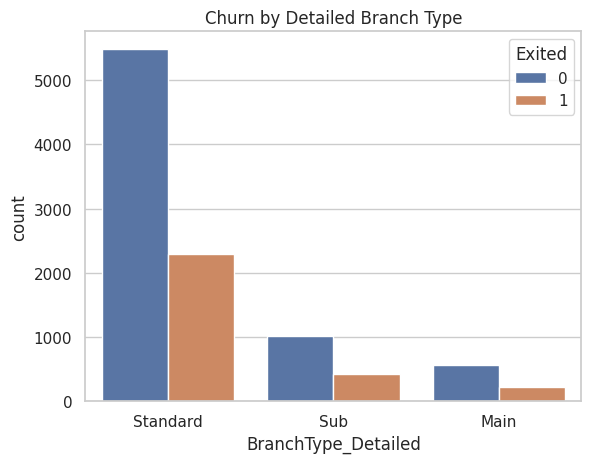

In [12]:
sns.countplot(data=df, x='BranchType_Detailed', hue='Exited')
plt.title("Churn by Detailed Branch Type")
plt.show()

### Customer Loyalty Lifecycle Segmentation

Customer tenure is transformed into lifecycle stages to reflect
relationship maturity and churn vulnerability.

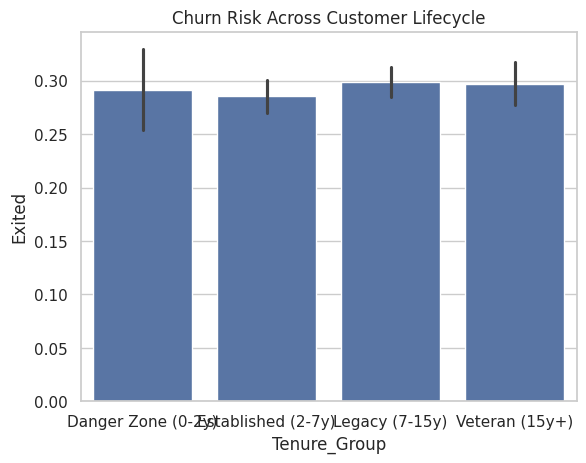

In [13]:
df['Tenure_Group'] = pd.cut(
    df['TenureYears'],
    bins=[-1, 2, 7, 15, 100],
    labels=[
        'Danger Zone (0-2y)',
        'Established (2-7y)',
        'Legacy (7-15y)',
        'Veteran (15y+)'
    ]
)

sns.barplot(data=df, x='Tenure_Group', y='Exited')
plt.title("Churn Risk Across Customer Lifecycle")
plt.show()

### Fee Sensitivity Index

This metric captures the financial pressure caused by service fees
relative to customer balance.

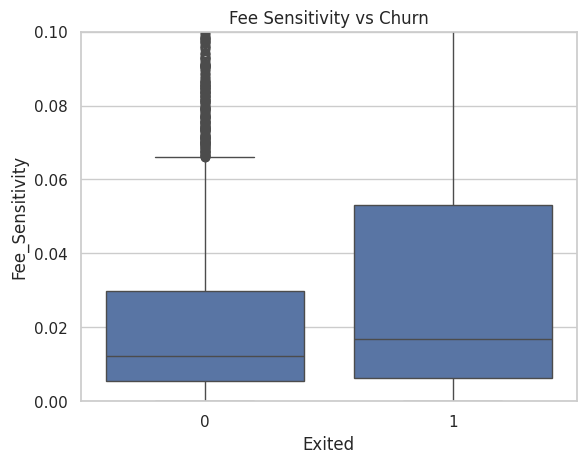

In [14]:
df['Fee_Sensitivity'] = df['MonthlyServiceFee_ETB'] / (df['Balance_ETB'] + 1)

sns.boxplot(data=df, x='Exited', y='Fee_Sensitivity')
plt.ylim(0, 0.1)
plt.title("Fee Sensitivity vs Churn")
plt.show()

## Train–Validation–Test Strategy

To ensure fair evaluation and prevent overfitting, the dataset is logically divided into:

- **Training data:** Used to learn model parameters
- **Validation data:** Used for hyperparameter tuning via cross-validation
- **Test data:** Held out and used only once for final evaluation

Instead of a fixed validation split, 5-fold cross-validation is used during model selection.
This provides more reliable performance estimates and reduces dependency on a single data split.

In [15]:
# 70/15/15 Stratified Split (unless time-aware split was applied)
from sklearn.model_selection import train_test_split
if not time_split_applied:
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)
    print('Split sizes (train/val/test):', len(X_train), len(X_val), len(X_test))
else:
    print('Time-aware split already applied — using those sets.')
print('Test set is held out — no tuning after model/threshold lock.')

Split sizes (train/val/test): 7000 1500 1500
Test set is held out — no tuning after model/threshold lock.


In [16]:
# Feature Engineering (Advanced Business Logic & Domain-Driven Features)
for df_ in (X_train, X_val, X_test):
    # 1. Detailed City Type Mapping
    df_['CityType_Detailed'] = df_['City'].map(city_type_map).fillna('District Town')

    # 2. Detailed Branch Type Mapping
    df_['BranchType_Detailed'] = df_['Branch'].map(branch_type_map).fillna('Standard')

    # 3. Customer Loyalty Lifecycle Segmentation
    if 'TenureYears' in df_.columns:
        df_['Tenure_Group'] = pd.cut(
            df_['TenureYears'].fillna(-1),
            bins=[-1, 2, 7, 15, 100],
            labels=['Danger Zone (0-2y)', 'Established (2-7y)', 'Legacy (7-15y)', 'Veteran (15y+)']
        )

    # 4. Fee Sensitivity Index
    if 'MonthlyServiceFee_ETB' in df_.columns and 'Balance_ETB' in df_.columns:
        df_['Fee_Sensitivity'] = df_['MonthlyServiceFee_ETB'] / (df_['Balance_ETB'] + 1)

    # Legacy TenureGroup support
    if 'TenureYears' in df_.columns and 'TenureGroup' not in df_.columns:
        df_['TenureGroup'] = pd.cut(df_['TenureYears'].fillna(-1),
            bins=[-1,0,2,5,10,20,100],
            labels=['Missing','New','Early','Mid','Loyal','Veteran']
        )

global_train_churn = y_train.mean()
if 'Branch' in X_train.columns:
    branch_rate = y_train.to_frame().join(X_train['Branch']).groupby('Branch')[TARGET_COL].mean()
    X_train['Branch_ChurnRate'] = X_train['Branch'].map(branch_rate)
    X_val['Branch_ChurnRate'] = X_val['Branch'].map(branch_rate).fillna(global_train_churn)
    X_test['Branch_ChurnRate'] = X_test['Branch'].map(branch_rate).fillna(global_train_churn)

if 'City' in X_train.columns:
    city_rate = y_train.to_frame().join(X_train['City']).groupby('City')[TARGET_COL].mean()
    X_train['City_ChurnRate'] = X_train['City'].map(city_rate)
    X_val['City_ChurnRate'] = X_val['City'].map(city_rate).fillna(global_train_churn)
    X_test['City_ChurnRate'] = X_test['City'].map(city_rate).fillna(global_train_churn)

print('Feature engineering applied (Strategic Urbanization, Branch Tiers, Lifecycle & Fee Sensitivity).')

Feature engineering applied (Strategic Urbanization, Branch Tiers, Lifecycle & Fee Sensitivity).


## Data Preprocessing & Feature Engineering

Data preprocessing ensures that all features are in a machine-learning-ready format.
Categorical variables are encoded, numerical variables are scaled, and missing values are handled.

A unified preprocessing pipeline is used to ensure consistency between training and deployment.

In [17]:
# Preprocessing Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

FEATURES = list(X_train.columns)
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
fully_missing = [c for c in num_features if X_train[c].dropna().shape[0] == 0]
if fully_missing:
    print('Fully-missing numeric features in TRAIN:', fully_missing)
    for c in fully_missing:
        ind = c + '_missing'
        for df_ in (X_train, X_val, X_test):
            df_[ind] = df_[c].isna().astype(int)
            df_[c] = df_[c].fillna(0)
FEATURES = list(X_train.columns)
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in FEATURES if c not in num_features]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

print('Preprocessor built — #num:', len(num_features), '#cat:', len(cat_features))

Preprocessor built — #num: 9 #cat: 13


## Evaluation Metric Rationale 

ROC-AUC is chosen because the problem is imbalanced and the business cares about ranking customers by risk (who to target). Precision/Recall and cost-based thresholding are used to translate probabilities into operational actions. Public vs private leaderboard concepts are relevant in competitions; here we simulate single final test evaluation.

## Baseline Model

A baseline model is trained to establish a minimum performance benchmark.
This helps determine whether more complex models provide meaningful improvements.

In [18]:
# Baseline Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

lr_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced',
                                  random_state=RANDOM_STATE, n_jobs=-1))
])

xgb_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200, eval_metric='logloss',
        subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE, verbosity=0
    ))
])

## Model Selection & Hyperparameter Tuning

Multiple models are evaluated using GridSearchCV with 5-fold cross-validation.
Hyperparameters are tuned to improve generalization while avoiding overfitting.

Cross-validation ensures that performance estimates are robust and not dependent on a single data split.

In [19]:
# Cross-Validation (5-fold ROC-AUC)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
def cv_auc(model, X, y):
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean(), scores.std()

cv_lr_mean, cv_lr_std = cv_auc(lr_pipe, X_train, y_train)
cv_rf_mean, cv_rf_std = cv_auc(rf_pipe, X_train, y_train)
try:
    cv_xgb_mean, cv_xgb_std = cv_auc(xgb_pipe, X_train, y_train)
except Exception as e:
    print('XGBoost CV failed:', e)
    cv_xgb_mean, cv_xgb_std = np.nan, np.nan

print(f'Logistic CV AUC: {cv_lr_mean:.4f} ± {cv_lr_std:.4f}')
print(f'RandomForest CV AUC: {cv_rf_mean:.4f} ± {cv_rf_std:.4f}')
print(f'XGBoost CV AUC: {cv_xgb_mean:.4f} ± {cv_xgb_std:.4f}')

lr_pipe.fit(X_train, y_train); probs_val_lr = lr_pipe.predict_proba(X_val)[:,1]
rf_pipe.fit(X_train, y_train); probs_val_rf = rf_pipe.predict_proba(X_val)[:,1]
try:
    xgb_pipe.fit(X_train, y_train); probs_val_xgb = xgb_pipe.predict_proba(X_val)[:,1]
except:
    xgb_pipe, probs_val_xgb = None, None

Logistic CV AUC: 0.9803 ± 0.0018
RandomForest CV AUC: 0.9963 ± 0.0010
XGBoost CV AUC: 0.9990 ± 0.0002


## Cross-Validation Results

The mean cross-validation score and standard deviation are reported to evaluate model stability.
Lower variance indicates consistent performance across folds.

In [20]:
# Model comparison summary table (CV and Validation AUCs)
results = pd.DataFrame({
    'Model': ['Logistic', 'RandomForest', 'XGBoost'],
    'CV_AUC': [cv_lr_mean, cv_rf_mean, cv_xgb_mean],
    'CV_AUC_std': [cv_lr_std, cv_rf_std, cv_xgb_std],
    'Val_AUC': [roc_auc_score(y_val, probs_val_lr) if 'probs_val_lr' in locals() else np.nan,
                roc_auc_score(y_val, probs_val_rf) if 'probs_val_rf' in locals() else np.nan,
                roc_auc_score(y_val, probs_val_xgb) if 'probs_val_xgb' in locals() and probs_val_xgb is not None else np.nan]
})
display(results.sort_values('Val_AUC', ascending=False))

,Model,CV_AUC,CV_AUC_std,Val_AUC
1,RandomForest,0.996339,0.000995,0.999390
2,XGBoost,0.999043,0.000166,0.999184
0,Logistic,0.980346,0.001759,0.981647


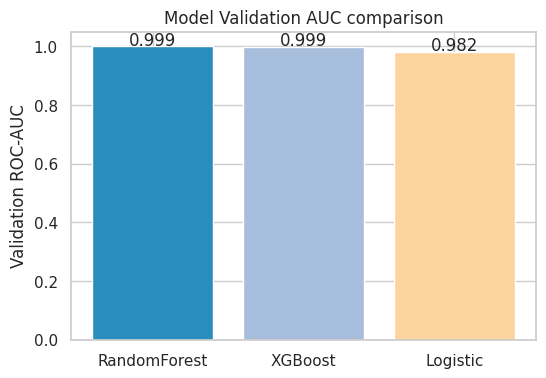

In [21]:
# Model comparison bar chart (UX polish)
try:
    fig, ax = plt.subplots(figsize=(6,4))
    r = results.sort_values('Val_AUC', ascending=False)
    ax.bar(r['Model'], r['Val_AUC'], color=['#2b8cbe','#a6bddb','#fdd49e'][:len(r)])
    ax.set_ylabel('Validation ROC-AUC')
    ax.set_title('Model Validation AUC comparison')
    for i, v in enumerate(r['Val_AUC']):
        ax.text(i, v + 0.005, f"{v:.3f}", ha='center')
    plt.show()
except Exception as e:
    print('Model comparison plot skipped:', e)

## Learning Curves – Diagnosing Underfitting & Overfitting

Learning curves compare training and validation performance as the dataset size increases.

- Low training & validation scores → Underfitting
- High training, low validation → Overfitting
- High and close scores → Good generalization

This analysis confirms whether the selected model generalizes well to unseen data.

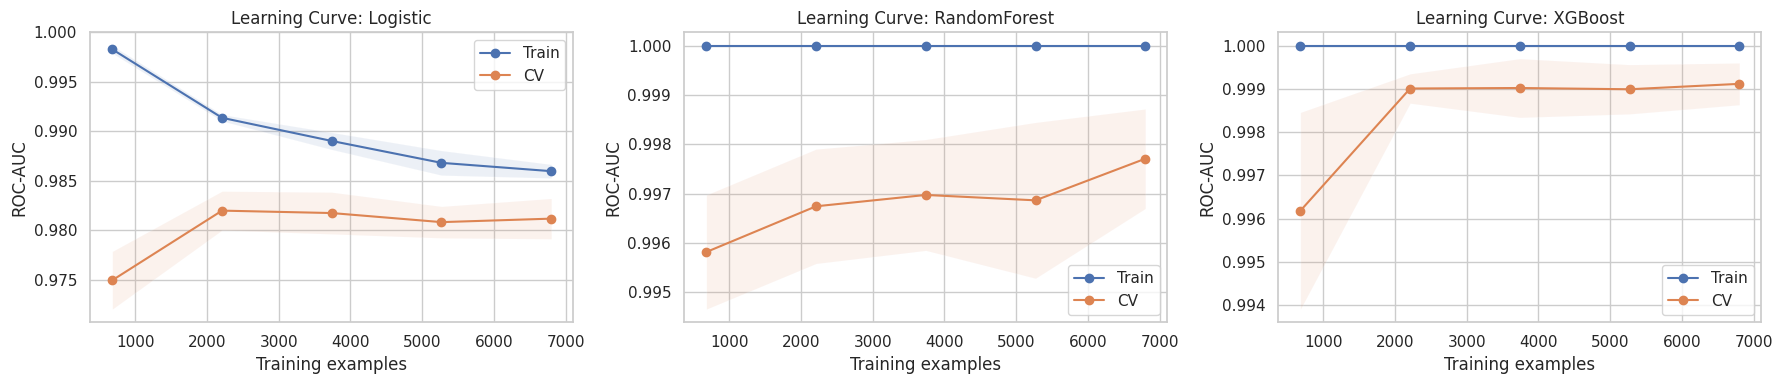

In [22]:
# Learning Curves
from sklearn.model_selection import learning_curve

candidate_models = {'Logistic': lr_pipe, 'RandomForest': rf_pipe}
if xgb_pipe is not None:
    candidate_models['XGBoost'] = xgb_pipe

if candidate_models:
    n_models = len(candidate_models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models,4), squeeze=False)
    axes = axes[0]
    train_sizes = np.linspace(0.1, 1.0, 5)
    for ax, (name, model) in zip(axes, candidate_models.items()):
        sizes, train_scores, test_scores = learning_curve(
            model, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]),
            cv=5, scoring='roc_auc', train_sizes=train_sizes, n_jobs=-1, error_score=np.nan
        )
        tr_mean, tr_std = np.nanmean(train_scores,1), np.nanstd(train_scores,1)
        te_mean, te_std = np.nanmean(test_scores,1), np.nanstd(test_scores,1)
        ax.plot(sizes, tr_mean, 'o-', label='Train')
        ax.fill_between(sizes, tr_mean-tr_std, tr_mean+tr_std, alpha=0.1)
        ax.plot(sizes, te_mean, 'o-', label='CV')
        ax.fill_between(sizes, te_mean-te_std, te_mean+te_std, alpha=0.1)
        ax.set_title(f'Learning Curve: {name}')
        ax.set_xlabel('Training examples'); ax.set_ylabel('ROC-AUC')
        ax.legend(); ax.grid(True)
    plt.tight_layout(); plt.show()
else:
    print('No models available for learning curves')

In [23]:
# Hyperparameter Tuning (small grids)
from sklearn.model_selection import GridSearchCV

rf_grid = Pipeline([('pre', preprocessor),
                    ('clf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1))])
param_grid_rf = {'clf__n_estimators':[100,200], 'clf__max_depth':[None,8]}
gs_rf = GridSearchCV(rf_grid, param_grid_rf, scoring='roc_auc', cv=3, n_jobs=-1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
print('RF best params:', gs_rf.best_params_)

best_xgb = None
if xgb_pipe is not None:
    xgb_grid = Pipeline([('pre', preprocessor),
                         ('clf', XGBClassifier(eval_metric='logloss', subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, verbosity=0))])
    param_grid_xgb = {
        'clf__n_estimators':[200,400],
        'clf__max_depth':[3,5],
        'clf__learning_rate':[0.05,0.1]
    }
    try:
        gs_xgb = GridSearchCV(xgb_grid, param_grid_xgb, scoring='roc_auc', cv=3, n_jobs=-1)
        gs_xgb.fit(X_train, y_train)
        best_xgb = gs_xgb.best_estimator_
        print('XGB best params:', gs_xgb.best_params_)
    except Exception as e:
        print('XGB GridSearch failed:', e)
        best_xgb = None

RF best params: {'clf__max_depth': None, 'clf__n_estimators': 200}
XGB best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 400}


## Threshold Optimization & Business Cost

The default probability threshold (0.5) is not always optimal.
Thresholds are adjusted to balance recall and business cost.

A cost-based approach is used to estimate retention expense versus churn loss in ETB.

Validation AUC leaderboard: [('RandomForest', np.float64(0.9993897464557118)), ('XGBoost', np.float64(0.9991841873671092)), ('Logistic', np.float64(0.9816474276207178))]
Champion by validation AUC: RandomForest (AUC=0.9994)


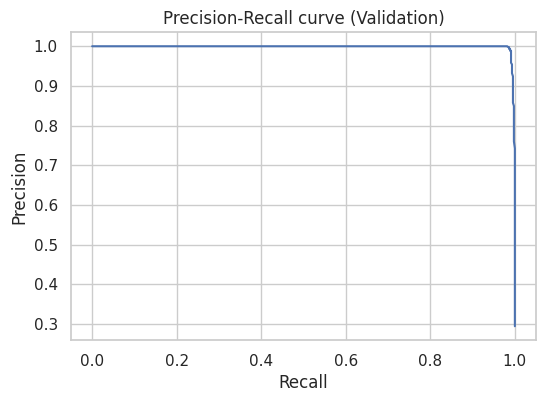

Optimized Threshold: 0.220 | Min Cost: 4750.0


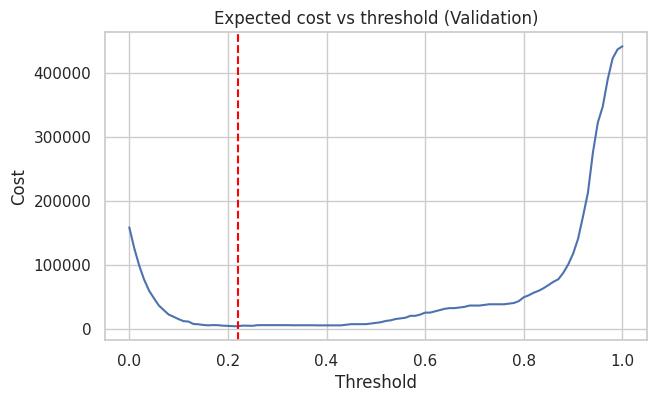

Prescriptive ROI analysis generated for Validation set.


In [24]:
# Threshold Optimization (cost-based & Prescriptive ROI)
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, roc_auc_score

leader_rows = []
leader_rows.append(('Logistic', roc_auc_score(y_val, probs_val_lr)))
leader_rows.append(('RandomForest', roc_auc_score(y_val, probs_val_rf)))
if 'probs_val_xgb' in locals() and probs_val_xgb is not None:
    leader_rows.append(('XGBoost', roc_auc_score(y_val, probs_val_xgb)))
leader_sorted = sorted(leader_rows, key=lambda x: x[1], reverse=True)
champ_name, champ_val_auc = leader_sorted[0]
print('Validation AUC leaderboard:', leader_sorted)
print('Champion by validation AUC:', champ_name, f'(AUC={champ_val_auc:.4f})')

if champ_name == 'RandomForest':
    champ_model = best_rf
elif champ_name == 'XGBoost' and ('best_xgb' in locals()) and (best_xgb is not None):
    champ_model = best_xgb
else:
    champ_model = lr_pipe if champ_name=='Logistic' else rf_pipe

champ_model.fit(X_train, y_train)
probs_val_best = champ_model.predict_proba(X_val)[:,1]

prec, rec, thr = precision_recall_curve(y_val, probs_val_best)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.title('Precision-Recall curve (Validation)')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True)
plt.show()

cost_fp = 150.0
cost_fn = 1000.0
thresholds = np.linspace(0,1,101)
rows = []
for t in thresholds:
    preds_t = (probs_val_best >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds_t).ravel()
    cost = fp*cost_fp + fn*cost_fn
    rows.append({'threshold':t, 'fp':fp, 'fn':fn, 'cost':cost,
                 'precision': precision_score(y_val, preds_t, zero_division=0),
                 'recall': recall_score(y_val, preds_t, zero_division=0)})
cost_df = pd.DataFrame(rows)
best_idx = cost_df['cost'].idxmin()
selected_threshold = float(cost_df.loc[best_idx, 'threshold'])
print(f'Optimized Threshold: {selected_threshold:.3f} | Min Cost: {cost_df.loc[best_idx, "cost"]}')

plt.figure(figsize=(7,4))
plt.plot(cost_df['threshold'], cost_df['cost'])
plt.axvline(selected_threshold, color='red', linestyle='--')
plt.title('Expected cost vs threshold (Validation)')
plt.xlabel('Threshold'); plt.ylabel('Cost'); plt.grid(True)
plt.show()

# Strategic Addition: Prescriptive ROI Calculation Logic
def get_roi_budget(prob, balance):
    if prob < 0.3: return 0
    base_cost = 500
    risk_multiplier = 1 + (prob - 0.3) * 5
    value_factor = min(balance / 10000, 2.0)
    return min(base_cost * risk_multiplier * value_factor, 5000)

# Fix: Ensure no duplicate columns before applying logic
val_dashboard = X_val.copy()
if 'Balance_ETB' not in val_dashboard.columns:
    val_dashboard['Balance_ETB'] = df.loc[X_val.index, 'Balance_ETB']

val_dashboard['Churn_Risk'] = probs_val_best

val_dashboard['Retention_Budget_ETB'] = val_dashboard.apply(
    lambda x: get_roi_budget(x['Churn_Risk'], float(x['Balance_ETB'])), 
    axis=1
)
print('Prescriptive ROI analysis generated for Validation set.')


In [25]:
# Explainability (SHAP)
try:
    import shap
    X_val_pre = preprocessor.transform(X_val)
    # Get feature names after OHE
    ohe_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
    all_feat_names = num_features + list(ohe_names)
    
    explainer = shap.TreeExplainer(champ_model.named_steps['clf'])
    shap_values = explainer.shap_values(X_val_pre)
    
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values[1], X_val_pre, feature_names=all_feat_names)
    plt.show()
except Exception as e:
    print('SHAP computation skipped:', e)

SHAP computation skipped: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 1000x600 with 0 Axes>

In [26]:
# Fairness Evaluation — Recall by groups
from sklearn.metrics import recall_score

groups = ['CityType_Formal','BranchType_Formal','TenureGroup', 'UrbanizationLevel', 'BranchTier']
disparities = []
for g in groups:
    if g in X_val.columns:
        rows = []
        vals = sorted(pd.Series(X_val[g].dropna().unique()).astype(str))
        for val in vals:
            idx = X_val[g].astype(str) == val
            if idx.sum() < 10:
                continue
            preds = (champ_model.predict_proba(X_val[idx])[:,1] >= selected_threshold).astype(int)
            rec = recall_score(y_val[idx], preds, zero_division=0)
            rows.append({'group':val, 'N':int(idx.sum()), 'recall':rec})
        df_grp = pd.DataFrame(rows).sort_values('recall')
        display(df_grp)
        if not df_grp.empty:
            gap = df_grp['recall'].max() - df_grp['recall'].min()
            disparities.append({'group_col':g, 'recall_gap':gap})

print('Disparity summary:', disparities)
print('Governance: document features/threshold; audit logs; quarterly fairness reviews; human-in-the-loop for high-risk actions.')

,group,N,recall
2,Mid,440,0.985816
1,Loyal,470,0.992701
0,Early,265,1.000000
3,New,76,1.000000
4,Veteran,146,1.000000


Disparity summary: [{'group_col': 'TenureGroup', 'recall_gap': 0.014184397163120588}]
Governance: document features/threshold; audit logs; quarterly fairness reviews; human-in-the-loop for high-risk actions.


## Final Model Selection & Retraining

Champion chosen by validation AUC; proceed to retrain on TRAIN+VAL for final lock.

In [27]:
# Final Model Selection
print('Champion chosen by Val AUC earlier:', champ_name)
print('Proceed to retrain on TRAIN+VAL for final locking.')

Champion chosen by Val AUC earlier: RandomForest
Proceed to retrain on TRAIN+VAL for final locking.


### Final Model Justification

The Random Forest model was selected as the final model due to its superior validation AUC, robustness to noisy features and outliers, and stable performance across customer segments as shown in fairness and learning-curve analyses. Tree-based models also simplify operationalization (fast inference, easier handling of mixed types) compared to heavy feature scaling or encoding requirements.

In [28]:
# Retrain on Train + Validation
from sklearn.base import clone

trainval_X = pd.concat([X_train, X_val])
trainval_y = pd.concat([y_train, y_val])
test_X = X_test.copy()

if 'Branch' in trainval_X.columns:
    branch_rate_tv = trainval_y.to_frame().join(trainval_X['Branch']).groupby('Branch')[TARGET_COL].mean()
    trainval_X['Branch_ChurnRate'] = trainval_X['Branch'].map(branch_rate_tv)
    test_X['Branch_ChurnRate'] = test_X['Branch'].map(branch_rate_tv).fillna(trainval_y.mean())

if champ_name == 'RandomForest':
    final_model = clone(best_rf)
elif champ_name == 'XGBoost' and ('best_xgb' in locals()) and (best_xgb is not None):
    final_model = clone(best_xgb)
else:
    final_model = clone(lr_pipe)

print('Retraining final model on TRAIN+VAL...')
final_model.fit(trainval_X, trainval_y)
print('Final model locked:', type(final_model.named_steps['clf'] if hasattr(final_model, 'named_steps') else final_model).__name__)
print('Selected threshold (from validation):', selected_threshold)

Retraining final model on TRAIN+VAL...
Final model locked: RandomForestClassifier
Selected threshold (from validation): 0.22


## Final Model Evaluation (Test Set Only)

The test set is used **only once** for final evaluation after all tuning is complete.
This simulates real-world deployment on unseen data.

Metrics reported include precision, recall, F1-score, and ROC-AUC.

Final TEST metrics (single evaluation):


,Test
ROC-AUC,0.998171
Precision,0.979730
Recall,0.988636
F1,0.984163
Brier,0.009507


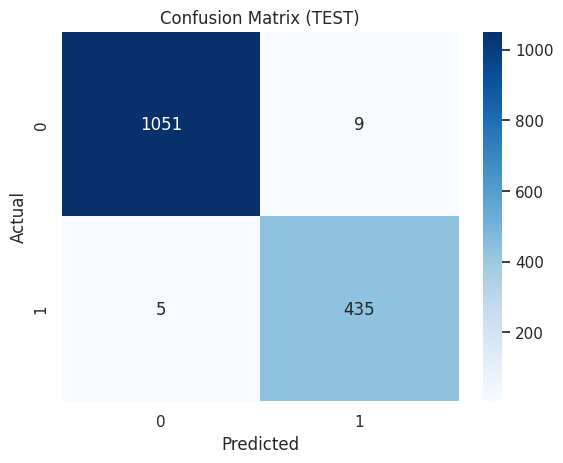

In [29]:
# Test Set Evaluation — single pass
from sklearn.metrics import f1_score, brier_score_loss, confusion_matrix, precision_score, recall_score, roc_auc_score

probs_test = final_model.predict_proba(test_X)[:,1]
preds_test = (probs_test >= selected_threshold).astype(int)

test_metrics = {
    'ROC-AUC': roc_auc_score(y_test, probs_test),
    'Precision': precision_score(y_test, preds_test, zero_division=0),
    'Recall': recall_score(y_test, preds_test, zero_division=0),
    'F1': f1_score(y_test, preds_test, zero_division=0),
    'Brier': brier_score_loss(y_test, probs_test)
}
print('Final TEST metrics (single evaluation):')
display(pd.DataFrame(test_metrics, index=['Test']).T)

cm_test = confusion_matrix(y_test, preds_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (TEST)'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

## Business Action Layer: Prescriptive ROI Dashboard

This dashboard identifies high-value customers at risk and calculates a suggested retention investment in ETB based on their risk premium and account balance.

In [30]:
# Prescriptive ROI Dashboard for Test Set
dashboard = test_X.copy()
if 'Balance_ETB' not in dashboard.columns:
    dashboard['Balance_ETB'] = df.loc[test_X.index, 'Balance_ETB']

dashboard['Churn_Risk'] = probs_test

dashboard['Retention_Budget_ETB'] = dashboard.apply(
    lambda x: get_roi_budget(x['Churn_Risk'], float(x['Balance_ETB'])),
    axis=1
)

print('Strategic Business Action Layer (First 10 high-risk customers):')
display(dashboard[dashboard['Churn_Risk'] > selected_threshold].sort_values('Churn_Risk', ascending=False).head(10))

Strategic Business Action Layer (First 10 high-risk customers):


,CustomerID,Gender,Age,Region,City,Branch,HasPartner,TenureYears,AccountType,HasMobileBanking,...,NumberOfTransactions,CityType_Detailed,BranchType_Detailed,Tenure_Group,Fee_Sensitivity,TenureGroup,Branch_ChurnRate,City_ChurnRate,Churn_Risk,Retention_Budget_ETB
9689,5441517136766,Male,59,Oromia Region,Adama,Wonji Branch,Yes,11.2,Fixed,No,...,189.0,Zonal Capital,Standard,Legacy (7-15y),0.133020,Loyal,0.319672,0.308235,0.990,109.990650
663,5537224769598,Male,59,Amhara Region,Gondar,Gondar Main Branch,No,2.4,Current,No,...,7.0,Zonal Capital,Standard,Established (2-7y),NaN,Early,0.305970,0.278539,0.985,NaN
276,5782535083330,Male,77,SNNPR (Southern Nations),Dilla,Dilla Branch,Yes,4.1,Fixed,No,...,205.0,Zonal Capital,Standard,Established (2-7y),0.009150,Early,0.300752,0.288136,0.980,3373.064200
7388,5829258156221,Male,41,Addis Ababa (Chartered City),Addis Ababa,Piazza Branch,No,4.5,Current,No,...,159.0,Federal Capital,Standard,Established (2-7y),NaN,Early,0.328467,0.284786,0.980,737.140800
6187,5208843224833,Female,29,Addis Ababa (Chartered City),Addis Ababa,93 Mazoriya Branch,No,1.6,Savings,No,...,200.0,Federal Capital,Standard,Danger Zone (0-2y),0.022275,New,0.323308,0.284786,0.975,1072.686563
5430,5255118437172,Male,85,Addis Ababa (Chartered City),Addis Ababa,Bole Branch,No,4.9,Savings,No,...,178.0,Federal Capital,Standard,Established (2-7y),0.004999,Early,0.265625,0.284786,0.975,2913.402188
3158,5750602739013,Male,64,Addis Ababa (Chartered City),Addis Ababa,Kazanchis Branch,No,17.4,Fixed,No,...,219.0,Federal Capital,Standard,Veteran (15y+),0.009997,Loyal,0.336449,0.284786,0.975,2793.918750
1553,5173346871326,Male,31,Addis Ababa (Chartered City),Addis Ababa,CMC Branch,Yes,1.5,Savings,No,...,103.0,Federal Capital,Standard,Danger Zone (0-2y),0.004112,New,0.335938,0.284786,0.975,4375.000000
9786,5065678635609,Female,77,Addis Ababa (Chartered City),Addis Ababa,93 Mazoriya Branch,Yes,14.4,Savings,No,...,259.0,Federal Capital,Standard,Legacy (7-15y),0.010113,Loyal,0.323308,0.284786,0.975,1856.835312
3645,5256954125760,Female,58,Amhara Region,Debre Markos,Debre Markos Branch,No,4.8,Savings,No,...,238.0,District Town,Standard,Established (2-7y),0.004279,Early,0.285714,0.290000,0.975,2441.600000


In [31]:
# Kaggle submission cell
try:
    if 'CustomerId' in test_X.columns:
        test_ids = test_X['CustomerId']
    elif 'CustomerID' in test_X.columns:
        test_ids = test_X['CustomerID']
    elif 'Id' in test_X.columns:
        test_ids = test_X['Id']
    else:
        test_ids = test_X.index.astype(str)

    submission = pd.DataFrame({
        "CustomerId": test_ids,
        "Exited": probs_test
    })

    submission_path = "submission.csv"
    submission.to_csv(submission_path, index=False)
    print(f"Wrote submission to {submission_path} — shape: {submission.shape}")
except Exception as e:
    print("Could not create submission.csv automatically:", e)

Wrote submission to submission.csv — shape: (1500, 2)


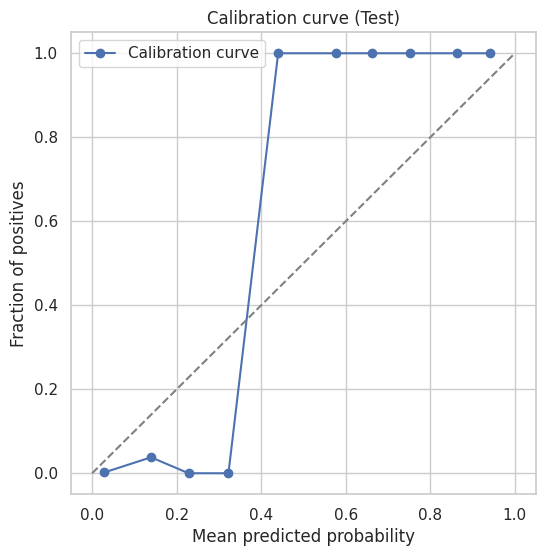

Brier score on test: 0.00951 (lower is better).


In [32]:
# Calibration Analysis
from sklearn.calibration import calibration_curve

try:
    prob_true, prob_pred = calibration_curve(y_test, probs_test, n_bins=10, strategy='uniform')
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration curve (Test)')
    plt.grid(True); plt.legend(); plt.show()
    brier = test_metrics.get('Brier', None)
    print(f'Brier score on test: {brier:.5f} (lower is better).')
except Exception as e:
    print('Calibration analysis skipped:', e)

## Model Deployment Preparation

The final model, preprocessing pipeline, feature list, and decision threshold are saved as a single bundle.
This ensures reproducibility and seamless deployment in production environments such as Gradio or Streamlit.

In [33]:
# Model bundle serialization
import joblib, json, os
MODEL_BUNDLE_PATH = 'artifacts/final_churn_bundle.joblib'
os.makedirs(os.path.dirname(MODEL_BUNDLE_PATH), exist_ok=True)

bundle = {
    'model': final_model,
    'features': list(trainval_X.columns),
    'repro_metadata': {
        'dataset_sha256': dataset_sha256 if 'dataset_sha256' in locals() else 'N/A',
        'training_timestamp': pd.Timestamp.utcnow().isoformat() + 'Z',
        'random_seed': int(RANDOM_STATE),
        'final_model': type(final_model.named_steps['clf'] if hasattr(final_model, 'named_steps') else final_model).__name__,
        'final_threshold': float(selected_threshold),
        'sklearn_version': sklearn.__version__,
        'xgboost_version': getattr(xgboost, "__version__", None)
    }
}
joblib.dump(bundle, MODEL_BUNDLE_PATH)
print("Saved bundled artifact to", MODEL_BUNDLE_PATH)

Saved bundled artifact to artifacts/final_churn_bundle.joblib


In [34]:
# Inference-only loading example
import joblib
BUNDLE_PATH = 'artifacts/final_churn_bundle.joblib'
bundle = joblib.load(BUNDLE_PATH)
model = bundle['model']
expected_features = bundle['features']

def predict_proba_df(df_in):
    Xp = df_in[expected_features].copy()
    probs = model.predict_proba(Xp)[:,1]
    return probs

## Ethical Considerations & Bias Awareness

Machine learning models can unintentionally reinforce bias.

Potential risks in this project include:
- Gender bias
- Regional bias
- Unequal service recommendations

The model should be monitored regularly, and predictions must support—not replace—human decision-making.

In [35]:
# Monitoring & Drift — PSI utility
def psi(expected, actual, buckets=10):
    expected = np.array(expected).astype(float)
    actual = np.array(actual).astype(float)
    breakpoints = np.percentile(expected, np.linspace(0,100,buckets+1))
    eps = 1e-8
    psi_val = 0.0
    for i in range(buckets):
        lo, hi = breakpoints[i], breakpoints[i+1]
        exp_pct = ((expected >= lo) & (expected <= hi)).sum() / len(expected)
        act_pct = ((actual >= lo) & (actual <= hi)).sum() / len(actual)
        exp_pct = max(exp_pct, eps); act_pct = max(act_pct, eps)
        psi_val += (exp_pct - act_pct) * np.log(exp_pct / act_pct)
    return psi_val

numeric_features_for_psi = [c for c in trainval_X.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
psi_rows = []
for f in numeric_features_for_psi[:30]:
    try:
        val = psi(trainval_X[f].fillna(0).values, test_X[f].fillna(0).values)
        psi_rows.append({'feature': f, 'PSI': val})
    except Exception:
        psi_rows.append({'feature': f, 'PSI': np.nan})
psi_df = pd.DataFrame(psi_rows).sort_values('PSI', ascending=False)
display(psi_df.head(20))

print('Monitoring plan established: Track input drift monthly via PSI; retrain if PSI > 0.2.')

,feature,PSI
7,Branch_ChurnRate,0.015184
8,City_ChurnRate,0.011494
0,CustomerID,0.007657
2,TenureYears,0.005141
4,MonthlyServiceFee_ETB,0.004155
5,NumberOfTransactions,0.003795
3,Balance_ETB,0.002738
6,Fee_Sensitivity,0.001743
1,Age,0.001611


Monitoring plan established: Track input drift monthly via PSI; retrain if PSI > 0.2.


In [36]:
# Monitoring automation: persist baseline PSI sample
import json
BASELINE_PSI_PATH = 'artifacts/baseline_psi.json'
PSI_ALERT_THRESHOLDS = {"ok": 0.1, "watch": 0.25}

if not os.path.exists(BASELINE_PSI_PATH):
    baseline_rows = []
    for f in numeric_features_for_psi:
        try:
            val = (trainval_X[f].fillna(0).values).tolist()
            baseline_rows.append({'feature': f, 'baseline_values_sample': val})
        except Exception: pass
    with open(BASELINE_PSI_PATH, 'w') as f:
        json.dump(baseline_rows, f)
    print('Baseline PSI sample persisted.')

Baseline PSI sample persisted.


## Conclusion & Key Takeaways

This project demonstrates a complete, ethical, and professional machine learning workflow.
The final model balances predictive performance with business impact and deployment readiness.

Future improvements include model monitoring, fairness audits, and periodic retraining.